In [15]:
import numpy as np 
import pandas as pd 
import h5py 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

%matplotlib inline 

In [21]:
figname='lt'
h5file=h5py.File("/Users/pablo/Development/PostNewton3BP/exe/Fig3_"+figname+"/output.h5")

In [48]:
h5file['0/fields/1/metric_0_0'][:]

array([[[ 1.00015998,  1.00015998,  1.00015998, ...,  1.00015995,
          1.00015995,  1.00015995],
        [ 1.00015993,  1.00015993,  1.00015993, ...,  1.0001599 ,
          1.0001599 ,  1.0001599 ],
        [ 1.00015988,  1.00015988,  1.00015988, ...,  1.00015985,
          1.00015985,  1.00015985],
        ..., 
        [ 1.00015694,  1.00015694,  1.00015694, ...,  1.00015692,
          1.00015692,  1.00015691],
        [ 1.0001569 ,  1.0001569 ,  1.0001569 , ...,  1.00015687,
          1.00015687,  1.00015687],
        [ 1.00015685,  1.00015685,  1.00015685, ...,  1.00015682,
          1.00015682,  1.00015682]],

       [[ 1.00015998,  1.00015998,  1.00015998, ...,  1.00015995,
          1.00015995,  1.00015995],
        [ 1.00015993,  1.00015993,  1.00015993, ...,  1.0001599 ,
          1.0001599 ,  1.0001599 ],
        [ 1.00015988,  1.00015988,  1.00015988, ...,  1.00015985,
          1.00015985,  1.00015985],
        ..., 
        [ 1.00015694,  1.00015694,  1.00015694, ...,

In [18]:
def get_waves(h5file):
    l_modes=[2,3] 
    columns=["t"]
    name=["Q","O","CQ"]
    for l in l_modes:
        for p in ['R','I']:
            for m in np.arange(start=-l,stop=l+1):
                columns.append(p+'['+name[l-2]+'m='+str(m)+"]")
    l=3
    for p in ['R','I']:
        for m in np.arange(start=-l,stop=l+1):
            columns.append(p+'['+name[l-1]+'m='+str(m)+"]")
    return pd.DataFrame(h5file['0']['waves'][:],columns=columns)       
    
df_waves=get_waves(h5file).set_index('t')

In [19]:
def get_dynamic_variable(h5file, dataset):
    Np=h5file['0'][dataset].attrs['np'][0]
    Dim=h5file['0'][dataset].attrs['dim'][0]
    coord=['x','y','z']    
    cols=['t']
    for p in np.arange(Np):
        for i in np.arange(Dim):
            cols.append(coord[i]+str(p+1))
    return pd.DataFrame(h5file['0'][dataset][:],columns=cols)


df_x=get_dynamic_variable(h5file, "position").set_index('t')
df_p=get_dynamic_variable(h5file, "momentum").set_index('t')

df_dxdt=get_dynamic_variable(h5file, "dxdt").set_index('t')
df_dpdt=get_dynamic_variable(h5file, "dpdt").set_index('t')

df_ddxdt2=get_dynamic_variable(h5file, "ddxdt2").set_index('t')
df_ddpdt2=get_dynamic_variable(h5file, "ddpdt2").set_index('t')

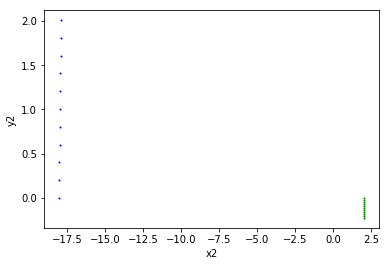

In [20]:
ax=df_x.plot.scatter(x='x1',y='y1',s=1,c='g')
ax=df_x.plot.scatter(x='x2',y='y2',s=1,c='b',ax=ax)


In [21]:
df_x[df_x['x1']>1.999804] #.plot()

,x1,y1,x2,y2
t,,,,
0,100018.000000,0.000000,100002.000000,0.000000
1,100017.999805,-0.022360,100002.001758,0.201238
2,100017.999219,-0.044714,100002.007031,0.402427
3,100017.998242,-0.067057,100002.015819,0.603517
4,100017.996875,-0.089384,100002.028121,0.804460
5,100017.995118,-0.111690,100002.043936,1.005207
6,100017.992971,-0.133967,100002.063263,1.205707
7,100017.990434,-0.156213,100002.086098,1.405913
8,100017.987507,-0.178419,100002.112441,1.605774


In [22]:
df_waves.to_csv('fig3_'+figname+'_wave.gp',sep='\t')

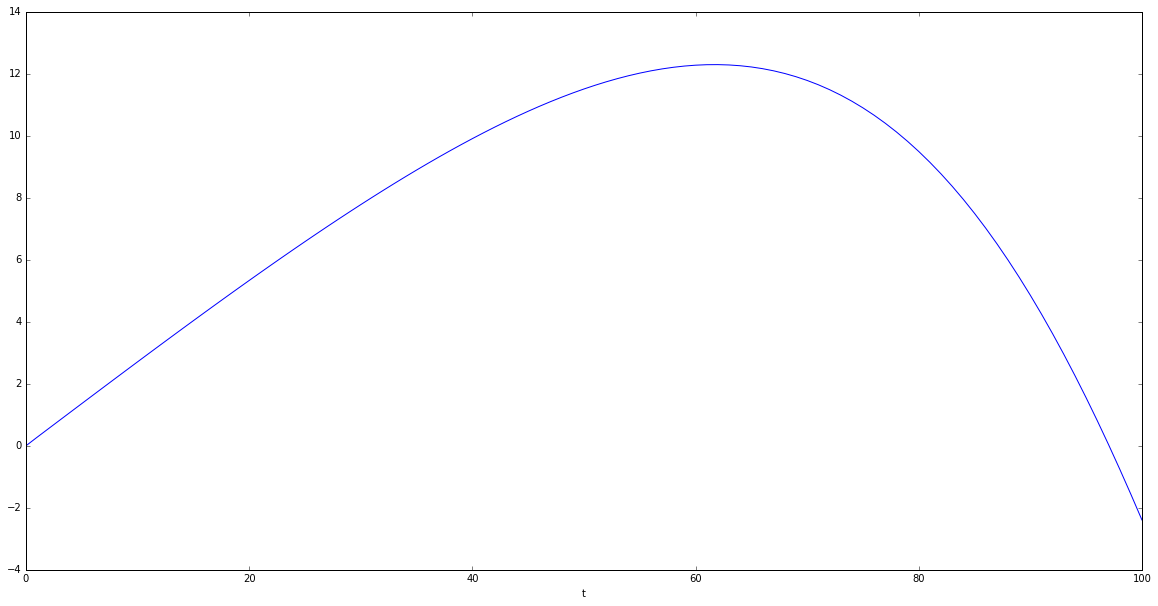

In [23]:
df_waves['R[Om=1]'].plot(figsize=(20,10))

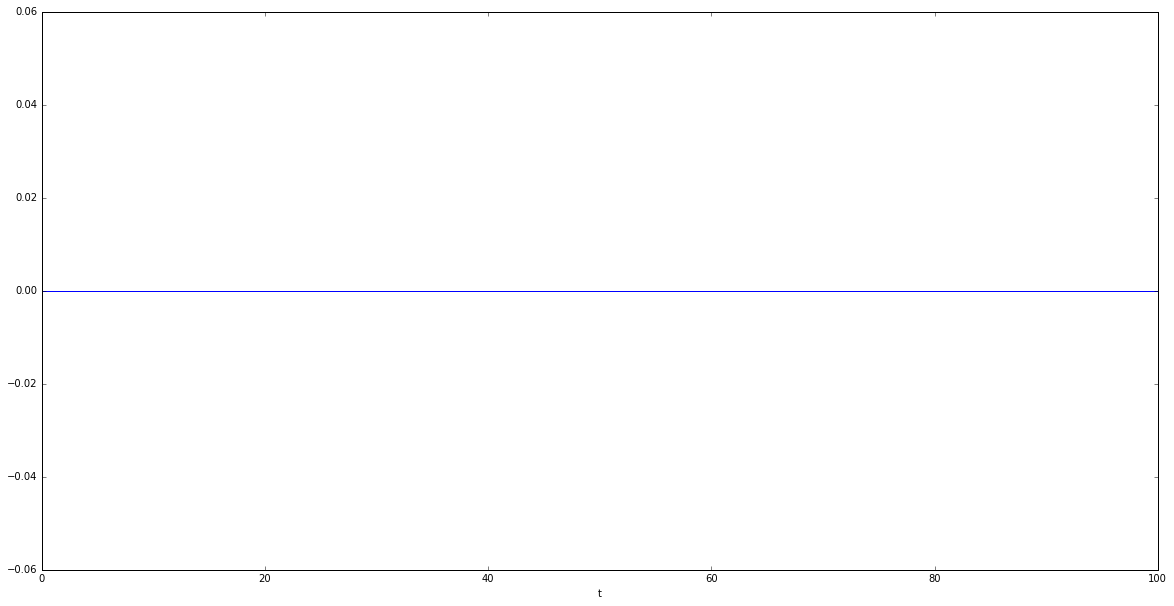

In [24]:
df_waves['R[Qm=-1]'].plot(figsize=(20,10))

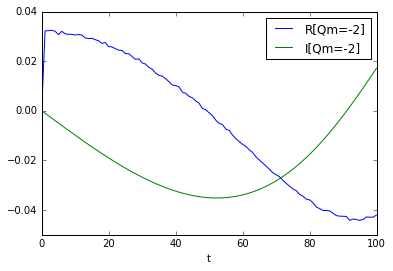

In [25]:
df_waves.iloc[:,(0,5)].plot()

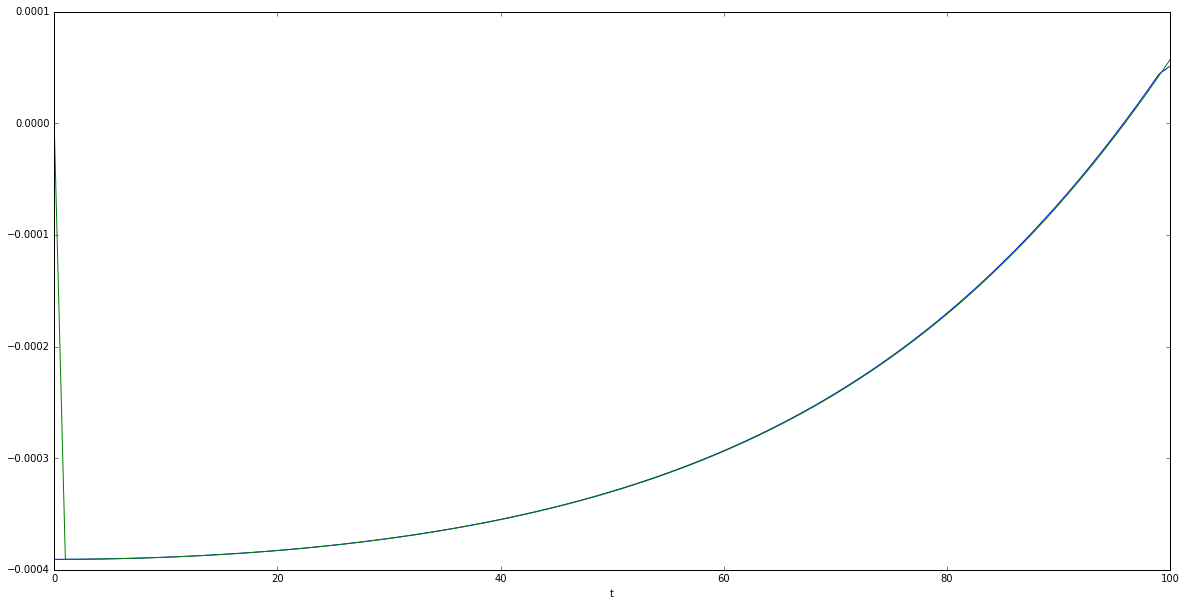

In [26]:
ax=pd.Series(np.gradient(df_dxdt['x1'].values,df_dxdt.index.values),index=df_dxdt.index).plot(figsize=(20,10))
(df_ddxdt2['x1']).plot(figsize=(20,10),ax=ax)


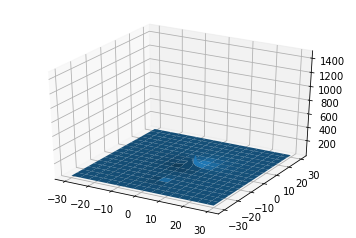

In [22]:
grid_size=h5file['coordinates/x'].shape
xc=h5file['coordinates/x'][:,:,grid_size[2]/2]
yc=h5file['coordinates/y'][:,:,grid_size[2]/2]
metric=h5file['0/fields/4/metric_0_0'][:,:,grid_size[2]/2]

fig_2d= plt.figure(1)
ax=fig_2d.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(xc, yc, metric, rstride=4, cstride=4, linewidth=0)

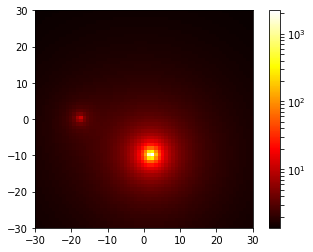

In [35]:
def plot_metric(i):
    grid_size=h5file['coordinates/x'].shape
    xc=h5file['coordinates/x'][:,:,grid_size[2]/2]
    yc=h5file['coordinates/y'][:,:,grid_size[2]/2]
    metric=h5file['0/fields/'+str(i)+'/metric_0_0'][:,:,grid_size[2]/2]
    plt.imshow(metric, extent=(np.amin(xc), np.amax(xc), np.amin(yc), np.amax(yc)),
            cmap=cm.hot, norm=LogNorm())
    plt.colorbar()
    plt.show()
    
plot_metric(11)

KeysView(<HDF5 group "/0/fields" (11 members)>)